# Detection of Pneumonia in Chest X-rays using Segmented CNN
##RSNA Pneumonia Detection Competition 
**CS 634  - Prof. Pantelis Monogioudis**

**Imran Hashmi, Jalaj Sharma, Lee Zhang**

Pneumonia, an infection of the lungs, is one of the top 10 causes of mortality in the United States. Diagnosing pneumonia is challenging and requires the domain expertise of a trained physician. Through this final project for Dr. Monogloudis' Machine Learning class, we will create a solution to the RSNA Pneumonia Detection Challenge by applying the methods of machine learning to detect the presence of lung opacities given a digital image of a x-ray. 

The challenges we will face will be similar to the ones facing the radiologists and specialists in the clinical setting - the pneumonia digital signal is represented by an opaque area of a chest x-ray. This signal can be clouded by the noise of other pathologies or even poor x-rays of normal lungs. To tackle these issues, our solution takes the following steps:


1.   Exploratory data analysis  - The sample and test data presented to us is in a rich DICOM format. This DICOM, or .dcm, file contains a significant amount of metadata including patient ID, age, gender and a trove of other data in addition to the chest x-ray image. We analyze not just the picture, but also mine the metadata for interesting patterns
2.   Residual convolutional neural network (resnet CNN) training - The heart of our solution is the resnet CNN that is built using the Keras library on top of the Tensorflow framework. We build a model from scratch and train the model on test chest x-rays which have been pre-labelled with pnuemonia opacities. This network segments the images with an emphasis on opacities. [We base the initial model build and training process from Jonne's Connected CNN kernal for this Kaggel challenge.](https://www.kaggle.com/jonnedtc/cnn-segmentation-connected-components) 
3.   Graph components for bounding boxes - we utilize connected components to recognize multiple opacities within a single chest x-ray image. Bounding boxes are drawn around each distinct opacity.

## Groundwork for the libraries and data pipeline

We will import various libraries which will help in reading, analyzing, and visualizing the data. This would include pydicom, os, and skimage for reading the dicom files. Seaborn, matlabplot, and pandas are used for analyzing and visualing the data.

We also import libraries used in creating the neural network. This would be the the Keras API within the Tensforflow framework.

In [0]:
import os  # For Reading file
import csv # creating csv sample submission
import random  # Shuffling image and data set to split in train and test 
!pip install -U -q pydicom # Needed to install 
import pydicom # Reading DMC Images or X-rays Images
import numpy as np # Converting images in array to feed in Neural Network
import pandas as pd # Read CSV
import multiprocessing
import seaborn as sns
import warnings
from skimage import io  #writing in folder and Input output processing
from skimage import measure  # cheking file size 
from skimage.transform import resize # converting File Size to pass in neural network

import tensorflow as tf # for CNN and network creating
from tensorflow import keras 

from matplotlib import pyplot as plt # ploting Images, Visualizaton library
import matplotlib.patches as patches

warnings.filterwarnings('ignore')

     |████████████████████████████████| 7.0MB 4.9MB/s 


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
 !pip install -U -q PyDrive
#Libraris to Download datasets from the Google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1mgH7u9T201TWJv4B0Jt6lrqOGQ5XOCXR' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

     |████████████████████████████████| 993kB 4.7MB/s 
title: stage_2_train_images.zip, id: 1fuFr2ufJg0IQmmhL9SS-KftC2mBSiOvK
downloading to /root/data/stage_2_train_images.zip
title: stage_2_test_images.zip, id: 1spJe0xHl8uzoj979YFyQaAHjwxhML14J
downloading to /root/data/stage_2_test_images.zip
title: stage_2_train_labels.csv, id: 1sUGhxUOmP1y6K27grJzo33p211G-tDy6
downloading to /root/data/stage_2_train_labels.csv
title: stage_2_detailed_class_info.csv, id: 1PCd_vFWvFdaY4sfHbHeY1qs5xn59h5IP
downloading to /root/data/stage_2_detailed_class_info.csv
title: GCP Credits Request Link - RSNA.txt, id: 18foUKQhel53TKsIEXf2oMSfcL57zGx21
downloading to /root/data/GCP Credits Request Link - RSNA.txt
title: stage_2_sample_submission.csv, id: 1A8uMPT7dTUjYW3a3TOaU3sGf9FIG32-M
downloading to /root/data/stage_2_sample_submission.csv


## Exploratory Data Analysis of the DICOM Files

Now that we have downloaded the data given to us, we will examine the training data found within stage_2_train_images.csv. This should show us how the images have been labelled to represent pneumonia opacities. We can see that we are given x and y coordinates as well as widgth and heigh of the opacitiy.

In [0]:
pd.read_csv('/root/data/stage_2_train_labels.csv').sample(8)

,patientId,x,y,width,height,Target
29111,043410c0-9453-4c89-a1d6-2ee846d8a343,NaN,NaN,NaN,NaN,0
7049,53d0a5ae-5e10-4812-b896-34c3dd12564e,NaN,NaN,NaN,NaN,0
10284,6df264b0-ab7f-471c-b371-7c4018fb43a4,130.0,404.0,213.0,133.0,1
1657,17c89450-d10e-4041-afa0-4c5a39adccdd,NaN,NaN,NaN,NaN,0
14124,8c68ceb7-2d5c-450e-bfda-052b862de063,131.0,162.0,305.0,558.0,1
21653,c4a01685-47a1-4ec1-86ac-78517e008b10,NaN,NaN,NaN,NaN,0
9959,6b6e92df-63fb-407d-9b69-e2de8ff1dcb8,NaN,NaN,NaN,NaN,0
9953,6b62a579-701d-4f40-bf5c-01c21f36f149,NaN,NaN,NaN,NaN,0


Looking at the other stage 2 csv training data, we find more information about the x-rays. Specifically we see that this detection problem can have three classes - normal, lung opacitiy (pneumonia), and not normal (no pneumonia). Not normal can indicate cancers or other pathologies which are outside the scope of this project.

In [0]:
pd.read_csv('/root/data/stage_2_detailed_class_info.csv').sample(8)

,patientId,class
5006,4352a923-34fe-41e7-9cce-7e2ff870ec4c,Normal
11257,756afc30-3d86-4a9b-886c-ddf0fb440fde,No Lung Opacity / Not Normal
22133,c86cf90f-07f4-49ea-a47e-1710b0cef2c3,No Lung Opacity / Not Normal
26734,ee169838-59a4-4628-8738-8c3b424ae4d5,No Lung Opacity / Not Normal
13620,8893aab9-24ab-4e67-8610-826f483a7145,Lung Opacity
2676,3375538a-8bb6-43af-9fe1-b9c462a597f7,Normal
4525,3f797a7b-4239-433a-8131-a1e3585712b3,Lung Opacity
29262,0fcd4b17-359c-40bf-a21c-907d0a91b5df,Normal


From both csv files we need to locate the lung opacity to correlate the coordiantes to the images which are given in the labelled stage_2_train_labels csv file. We will then create a dictionary to list each filename and the opacities associated with that file.

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('/root/data/stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In addition to the dictionary, we also instantiate a dataframe for easier manipulation of the data using Keras.

In [0]:
data_frame = pd.read_csv('/root/data/stage_2_train_labels.csv')
data_frame['aspect_ratio'] = (data_frame['width']/data_frame['height'])
data_frame['area'] = data_frame['width'] * data_frame['height']

print(pneumonia_locations)

{'00436515-870c-4b36-a041-de91049b9ab4': [[264, 152, 213, 379], [562, 152, 256, 453]], '00704310-78a8-4b38-8475-49f4573b2dbb': [[323, 577, 160, 104], [695, 575, 162, 137]], '00aecb01-a116-45a2-956c-08d2fa55433f': [[288, 322, 94, 135], [547, 299, 119, 165]], '00c0b293-48e7-4e16-ac76-9269ba535a62': [[306, 544, 168, 244], [650, 511, 206, 284]], '00f08de1-517e-4652-a04f-d1dc9ee48593': [[181, 184, 206, 506], [571, 275, 230, 476]], '0100515c-5204-4f31-98e0-f35e4b00004a': [[703, 416, 84, 77]], '010ccb9f-6d46-4380-af11-84f87397a1b8': [[652, 437, 161, 293], [301, 405, 141, 279]], '012a5620-d082-4bb8-9b3b-e72d8938000c': [[133, 613, 275, 275], [678, 427, 224, 340]], '0174c4bb-28f5-41e3-a13f-a396badc18bd': [[155, 182, 273, 501], [599, 220, 227, 508]], '019d950b-dd38-4cf3-a686-527a75728be6': [[229, 318, 250, 301], [604, 216, 196, 328]], '01a6eaa6-222f-4ea8-9874-bbd89dc1a1ce': [[141, 306, 225, 327], [609, 285, 236, 355]], '01a7353d-25bb-4ff8-916b-f50dd541dccf': [[214, 582, 239, 133], [664, 540, 223,

In [0]:
!mkdir stage_2_train_images
os.chdir('stage_2_train_images')
!unzip -qq /root/data/stage_2_train_images.zip

Now that we have a pipeline for our necessary training data setup, we now also analyze the dicom files to see what metadata is stored inside. Interestingly, we can see a whole variety of data that were not directly mentioned as part of the problem statement. To see if we can make use of this data, we decide to explore its relationship with lung opacities. 

In [0]:
patientId = data_frame['patientId'][4]
dcm_file = '%s.dcm' % patientId
dcm_data = pydicom.read_file(dcm_file)
print(dcm_data)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0020) Patient ID                          LO: '00436515-870c-4b36-a041-de91049b9ab4'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [0]:
print("Number of Total Train Images with opacities",len(os.listdir('/content/stage_2_train_images/')))
print("Number of opacities in train CSV file",data_frame.shape[0])

Number of Total Train Images with opacities 26684
Number of opacities in train CSV file 30227


In [0]:
data_frame.sample(10)

,patientId,x,y,width,height,Target,aspect_ratio,area
23364,d258b81b-f7b4-47f7-b850-3eca636d3a8c,NaN,NaN,NaN,NaN,0,NaN,NaN
5024,436e1ed4-19da-4d91-bae2-b06eec8c1a6a,NaN,NaN,NaN,NaN,0,NaN,NaN
5848,4a23a81a-3f1f-4089-9640-445949be88e2,NaN,NaN,NaN,NaN,0,NaN,NaN
30088,2f6ac842-e243-4c5f-a48c-d70862e316d5,NaN,NaN,NaN,NaN,0,NaN,NaN
14789,917b5947-334e-4642-98d5-8b801b523874,NaN,NaN,NaN,NaN,0,NaN,NaN
12748,815db394-98bf-4a2d-957a-968e2ef365ea,NaN,NaN,NaN,NaN,0,NaN,NaN
6298,4dd73b83-0d4a-4755-934a-25c4fb06dc01,NaN,NaN,NaN,NaN,0,NaN,NaN
29754,245d1104-6524-4d44-ace9-e54f0645a46e,532.0,568.0,148.0,210.0,1,0.704762,31080.0
10075,6c4fa583-73be-470e-8248-b75c309c2624,NaN,NaN,NaN,NaN,0,NaN,NaN
12945,83094251-fcda-4f05-a02c-00b6fd9d764b,690.0,203.0,328.0,668.0,1,0.491018,219104.0


By looking above information we can see that 3593 images that have multiple lung opacity. The patients who have multiple lung opacities are given separate locations in the csv so patient IDs have different locations and target values.

Let us now visualize the information present in the each Image we are processing. From the metadata printout we saw above, we have pixel spacing, patent ID, gender, age, and pixel data(Pixel Array) that seem very promising.

In [0]:
def get_dcim_info(filename):
  fn = os.path.join('',f'{filename}.dcm')
  dcm_data = pydicom.read_file(fn)
  return {'age': dcm_data.PatientAge,
         'gender': dcm_data.PatientSex,
         'id': dcm_data.PatientID,
         'pixel_spacing': float(dcm_data.PixelSpacing[0]),
         'mean_black_pixels': np.mean(dcm_data.pixel_array == 0)}


patient_ids = list(data_frame.patientId.unique())
with multiprocessing.Pool(4) as pool:
    result = pool.map(get_dcim_info, patient_ids)
    
demo = pd.DataFrame(result)
demo['gender'] = demo['gender'].astype('category')
demo['age'] = demo['age'].astype(int)

data_frame = (data_frame.merge(demo, left_on='patientId', right_on='id', how='left')
        .drop(columns='id'))


This Plot will Give us idea in training set number of images has pnemonia out of total In true and False

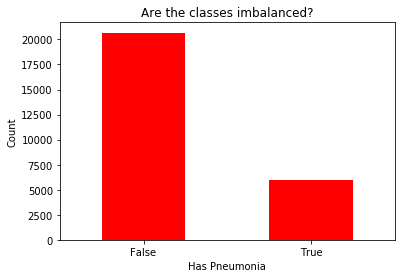

In [0]:
boxes_per_patient = data_frame.groupby('patientId')['Target'].sum()

ax = (boxes_per_patient > 0).value_counts().plot.bar( color = 'r')
_ = ax.set_title('Are the classes imbalanced?')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)


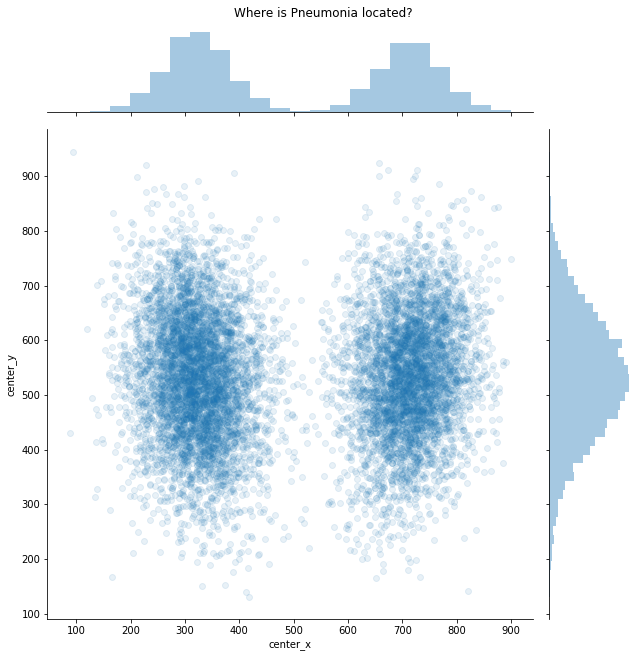

In [0]:
centers = (data_frame.dropna(subset=['x'])
           .assign(center_x=data_frame.x + data_frame.width / 2, center_y=data_frame.y + data_frame.height / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)

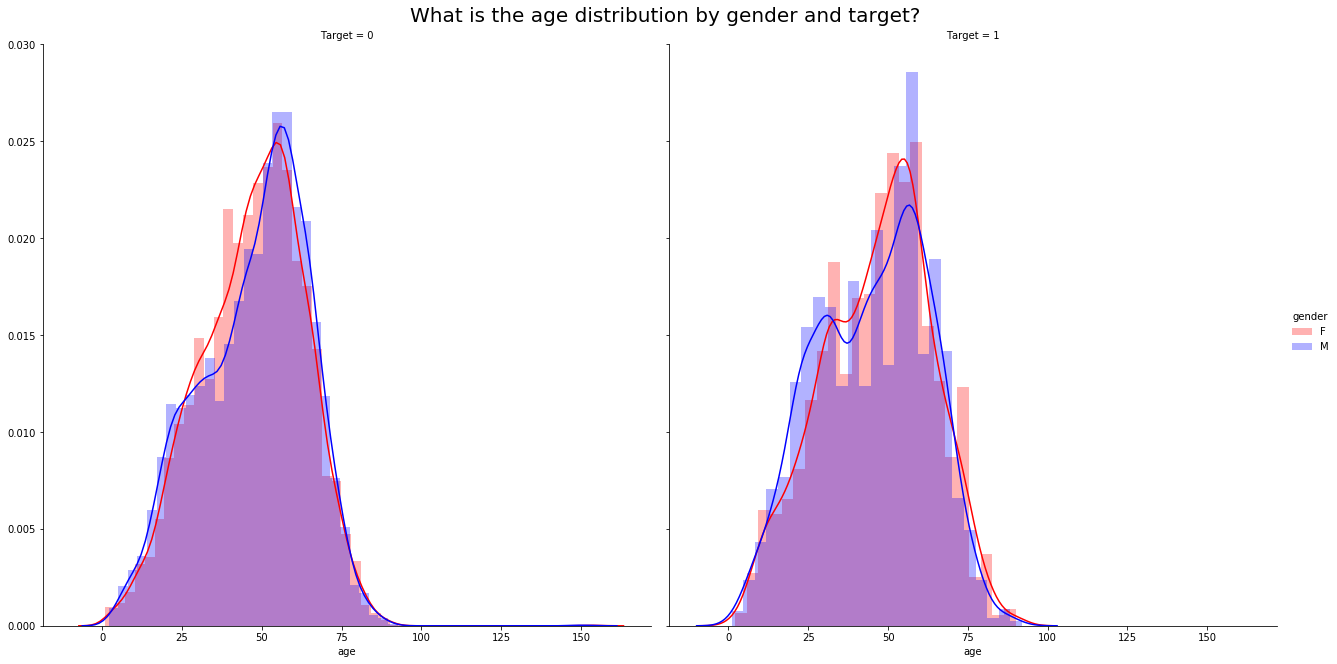

In [0]:
g = sns.FacetGrid(col='Target', hue='gender', 
                  data=data_frame.drop_duplicates(subset=['patientId']), 
                  height=9, palette=dict(F="red", M="blue"))
_ = g.map(sns.distplot, 'age', hist_kws={'alpha': 0.3}).add_legend()
_ = g.fig.suptitle("What is the age distribution by gender and target?", y=1.02, fontsize=20)

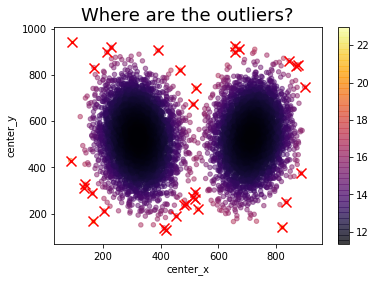

In [0]:
from sklearn.mixture import GaussianMixture
clf = GaussianMixture(n_components=2)
clf.fit(centers[['center_x', 'center_y']])
center_probs = clf.predict_proba(centers[['center_x', 'center_y']])
Z = -clf.score_samples(centers[['center_x', 'center_y']])
outliers = centers.iloc[Z > 17]
fig, ax = plt.subplots()
centers.plot.scatter('center_x', 'center_y', c=Z, alpha=0.5, cmap='inferno', ax=ax)
outliers.plot.scatter('center_x', 'center_y', c='red', marker='x', s=100, ax=ax)
_ = ax.set_title('Where are the outliers?', fontsize=18)

In [0]:
# load and shuffle filenames
os.chdir('..')
folder = '/content/stage_2_train_images/'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2200
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24484
n valid samples 2200


Total train images: 26684
Images with pneumonia: 6012


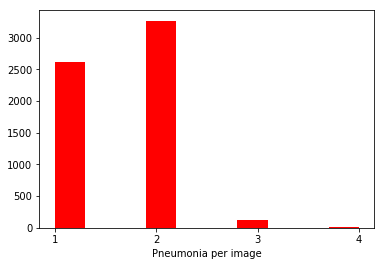

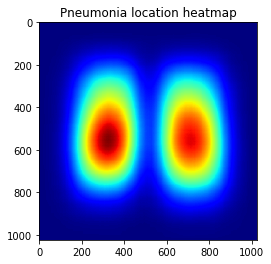

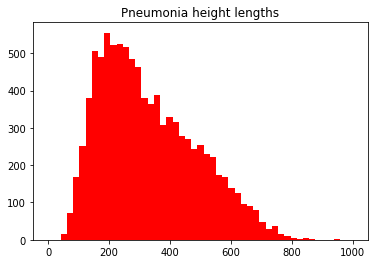

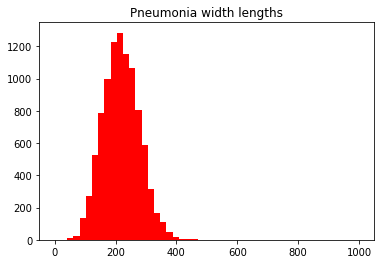

Minimum pneumonia height: 45
Minimum pneumonia width:  40


In [0]:
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

ns = [len(value) for value in pneumonia_locations.values()]
plt.figure()
plt.hist(ns, color = 'r')
plt.xlabel('Pneumonia per image')
plt.xticks(range(1, np.max(ns)+1))
plt.show()

heatmap = np.zeros((1024, 1024))
ws = []
hs = []
for values in pneumonia_locations.values():
    for value in values:
        x, y, w, h = value
        heatmap[y:y+h, x:x+w] += 1
        ws.append(w)
        hs.append(h)
plt.figure()
plt.title('Pneumonia location heatmap')
plt.imshow(heatmap, cmap='jet')
plt.figure()
plt.title('Pneumonia height lengths')
plt.hist(hs, bins=np.linspace(0,1000,50), color = 'r')
plt.show()
plt.figure()
plt.title('Pneumonia width lengths')
plt.hist(ws, bins=np.linspace(0,1000,50), color = 'r')
plt.show()
print('Minimum pneumonia height:', np.min(hs))
print('Minimum pneumonia width: ', np.min(ws))

Will return the pridicted bloack for Images 

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

##Creating the Neural Network

Our model ResNet CNN consists of four general parts. Input, downsampling, residual blocks, and then upsampling. We have used Alex Lenail's neural network diagram tool to show these layers which we are adding to our model. Our model effectively has 76 Keras layers if you include the batchnormalizaiton, leakyRelu, and add Keras layers. We perform batch normalization to normalize all our data in preparation for model training, and then we use a LeakyRelu activation function as we find that is the most effective in achieving a higher accuracy.

### Input
The input to our model is a 1024x1024 pixel image with we have downsampled to 256x256 pixel image for compute speed. This input layer has a conv2D Keras layer.
![Input Layer](https://i.imgur.com/ESTW2GO.png)

### Downsampling
Next, we see the downsampling layer. This downsampling layer is done four times for each input so that we start with a 256 pixel input one depth input but end with with a 32 x 32 filter with a depth of four. In the diagram below, we only see one such iteration of this downsampling. It is comprised of a 2dconv layer and then a maxpooling layer so that the downsampling averages out the values. This gives us a total of 16 Keras layers.
![Downsampling](https://i.imgur.com/02fNQOUg.png)

### Residual Blocks
These blocks create our ResNet. They feed the inputs straight on through to nearby and higher level layers in order to reduce and prevent the degradation of the data. We see this in the diagram in so far as it passes data straight through to the next layer. Note that these layers interconnect and lay "on top" of the downsampling and other layers.
![ResNet](https://i.imgur.com/hFW7WrO.png)
In the code below, these layers are nested in a for loop, so the residual blocks, which are composed of two 2dconv layers are run eight times each. This gives us a total of 48 Keras layers.



In [0]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

The kaggel challenge makes efforts to define the grading system that will be applied. It is the Jaccard loss function, or intersection over union (IoU). We combine it with a binary cross entropy (bce) loss. The IoU measurement is one of accuracy. 
![intersection over union](https://storage.googleapis.com/kaggle-media/competitions/rsna/IoU.jpg)

In [0]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = '/content/stage_2_train_images/'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=256, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=10, workers=4, use_multiprocessing=True)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
765/765 [==============================] - 1236s 2s/step - loss: 15.5332 - acc: 0.9607 - mean_iou: 0.6172 - val_loss: 16.6349 - val_acc: 0.9393 - val_mean_iou: 0.3005
Epoch 2/10
765/765 [==============================] - 949s 1s/step - loss: 14.5496 - acc: 0.9655 - mean_iou: 0.6591 - val_loss: 14.8686 - val_acc: 0.9726 - val_mean_iou: 0.7209
Epoch 3/10
765/765 [==============================] - 1000s 1s/step - loss: 14.1991 - acc: 0.9668 - mean_iou: 0.6730 - val_loss: 23.2051 - val_acc: 0.8250 - val_mean_iou: 0.1403
Epoch 4/10
765/765 [==============================] - 1006s 1s/step - loss: 13.9678 - acc: 0.9676 - mean_iou: 0.6768 - val_loss: 14.1292 - val_acc: 0.9699 - val_mean_iou: 0.6734
Epoch 5/10
765/765 [==============================] - 1014s 1s/step - loss: 13.7073 - acc: 0.9684 - mean_iou: 0.6848 - val_loss: 14.2350 - val_acc: 0.9584 - val_mean_iou

In [0]:
#scores = model.evaluate(train_gen, verbose = 0)c

#print("Accuracy: {} \n Error: {}".format(scores[1]*100, 100-scores[1]*100))

## Validating the Model
In order to compare and see how well our model performed, we plot the training and validation loss, the trianing accuracy and validation accuracy, and the training Intersection Over Union and validation Intersection over Union.

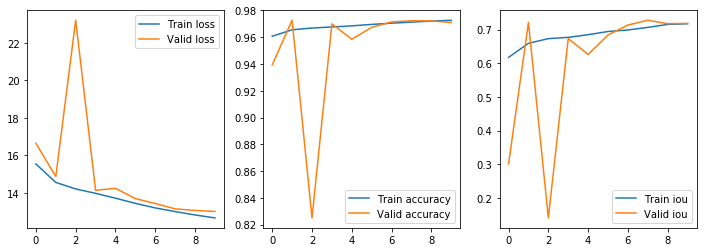

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

## Connected Components and Bounding Box Creation
Here we finally draw the bounding boxes around each opacity using connected components. Note that the threshold we are setting is 0.5.

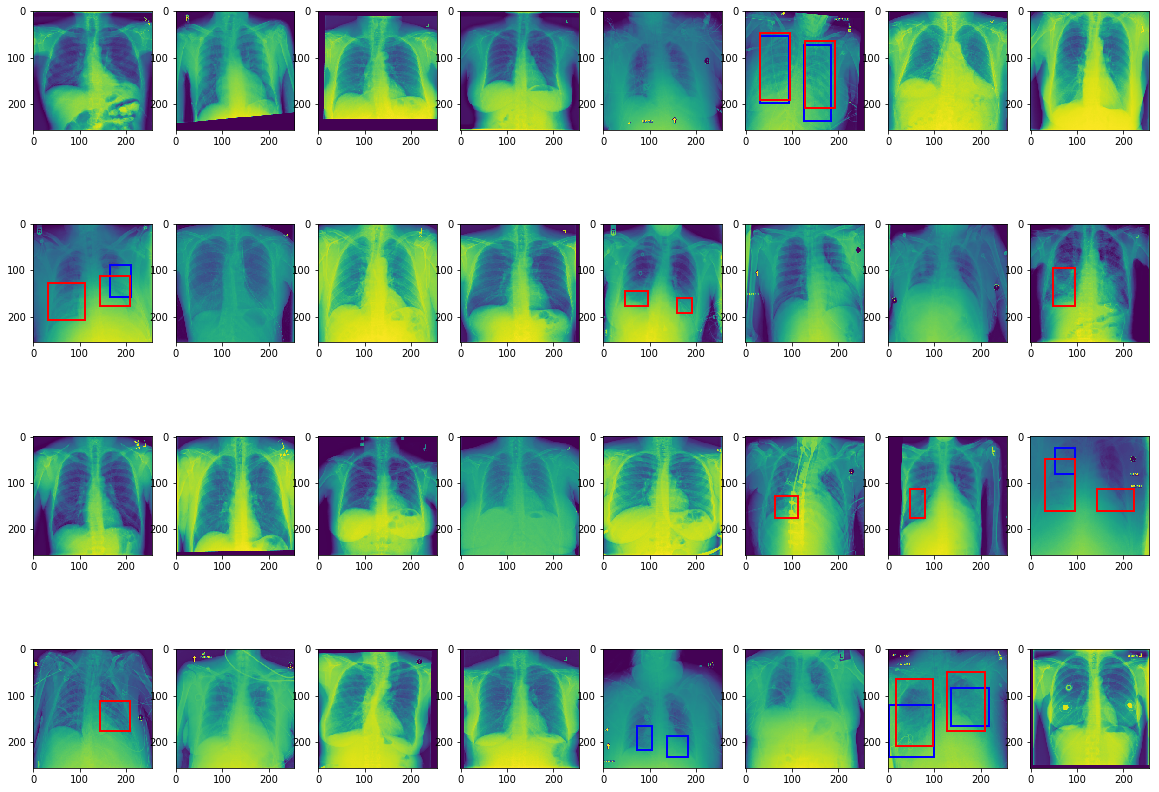

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

Now that we have trained our model, we change the directory from Train Images back to the test image folder and unzip it.

In [0]:
cd ..

!mkdir stage_2_test_images
os.chdir('stage_2_test_images')
!unzip -qq /root/data/stage_2_test_images.zip

/


Finally we can generate our submission file. We call our trained resnet CNN using the test images as our data set.

In [0]:
# load and shuffle filenames
folder = '../stage_2_test_images/'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size=256, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
display_output = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        areamap = []
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            areamap += [x ,y, width, height]
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
        display_output[filename] = areamap
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

n test samples: 3000


##Visualizing the Results
We see that based on our predictions we have 844 opacities and 2156 non-opacity images, postiive and negative images respectively.

People with Pneumonia is: 
False    2156
True      844
Name: PredictionString, dtype: int64


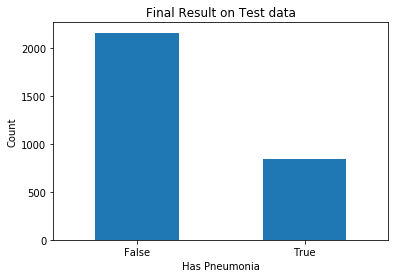

In [0]:
boxes_per_patient = sub.groupby('patientId')['PredictionString'].sum()

ax = (boxes_per_patient > '' ).value_counts().plot.bar()
_ = ax.set_title('Final Result on Test data')
_ = ax.set_xlabel('Has Pneumonia')
_ = ax.set_ylabel('Count')
_ = ax.xaxis.set_tick_params(rotation=0)

print("People with Pneumonia is: \n" + str((boxes_per_patient > '' ).value_counts()))


In [0]:
disp = pd.DataFrame.from_dict(display_output,orient='index')
disp.index.names = ['patientId']
disp.dropna(subset=[0],inplace=True)

We can spatially view our predicted results and it seems to match up to our testing heatmap. The pneumonia is concentrated in the center of the lungs and get sparser as you go towards the edges.

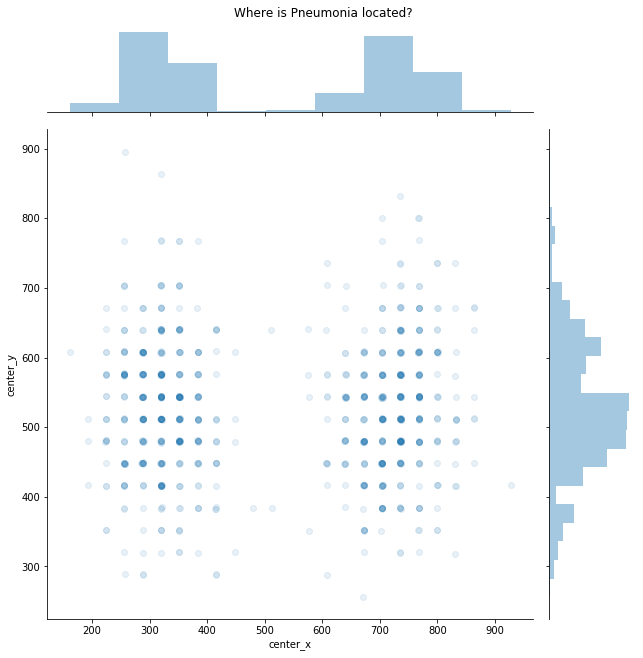

In [0]:
centers = (disp.dropna(subset=[0])
           .assign(center_x=disp[0] + disp[2] / 2, center_y=disp[1] + disp[3] / 2))
ax = sns.jointplot("center_x", "center_y", data=centers, height=9, alpha=0.1)
_ = ax.fig.suptitle("Where is Pneumonia located?", y=1.01)



In [0]:
os.chdir('/content')

The last thing we do is save our dataframe to a csv as our final submission.

In [0]:
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')